In [56]:
from scipy.stats import spearmanr, pearsonr, kendalltau
from statistics import mean, stdev, median
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
from math import isnan

In [57]:
# normalize scores of new given scores of base
def normalize_scores(new, base):
    assert len(new)==len(base)
    for i in range(len(new)):
        stmp = new['scores'][i]
        assert len(stmp)==4
        new['scores'][i] = [stmp[j]*-1/base['scores'][i][j] for j in range(len(stmp))]
    return new['scores']

def create_scores(indf):
    scos = []
    for i, row in indf.iterrows():
        ifs = [row['completions'][j]['annotations']['instruction_following'][0]['Rating'] for j in range(4)]
        hfs = [row['completions'][j]['annotations']['helpfulness'][0]['Rating'] for j in range(4)]
        #print(ifs)
        scos.append([mean([float(ifs[j]), float(hfs[j])]) for j in range(4)])
    return scos

# notebook for experiment to get inter-RM correlations (measure of distribution shift) at different stages of PPO
def load_jsons(basedir="../../outputs/ultrarmscos/", max=50):
    adicts = {}
    for l in os.listdir(basedir):
        kv = l.split("_")
        #print(kv)
        if kv[0] not in adicts.keys():
            adicts[kv[0]] = {}
        tmp = pd.read_json(basedir+l, orient='records', lines=True)
        if "dpo" in kv[1] or "tulu" in kv[1]:
            tmp['scores'] = [[sum(s) for s in row] for row in tmp['scores']]
        if "annotated" in kv[1]:
            # these are gold annotations
            tmp['scores'] = create_scores(tmp)
        adicts[kv[0]][kv[1].replace(".jsonl", "")] = tmp.loc[:50]

    for k in adicts.keys():
        tmp = adicts[k]
        for j in tmp.keys():
            if 'dpo' in j:
                print(j)
                tmp[j]['scores'] = normalize_scores(tmp[j], tmp[j.replace('dpo', 'tulu')])
            
    return adicts

alldata = load_jsons()

dpo13b
dpo7b
dpo7b
dpo13b
dpo7b
dpo13b
dpo13b
dpo7b
dpo7b
dpo13b
dpo7b
dpo13b
dpo7b
dpo13b
dpo7b
dpo13b
dpo7b
dpo13b


In [58]:
annots = pd.read_json('../../annotation/minitest_annotated.jsonl', lines=True, orient='records')

In [ ]:
annots['completions'][0][2]['annotations']['instruction_following'][0]['Rating']

In [ ]:
alldata['sft']['dpo13b']

In [11]:
alldata['u975'].keys()

dict_keys(['dpo7b', '13brm', 'tulu7b', '7brm', 'tulu13b', 'annotated'])

In [59]:
def valspear(subdict, comp, domean=True):
    corrs = {}
    for k in subdict.keys():
        if comp==k:
            continue
        #print(len(subdict))
        corr = [spearmanr(subdict[k]['scores'][i], subdict[comp]['scores'][i]).statistic for i in range(len(subdict[comp]))]
        if domean:
            corr = np.nanmean(corr)
        #print(k, " ", comp, " : ", corr)
        corrs[k] = corr
    return corrs

def varcals(subdict,domean=True, fun=stdev) :
    corrs = {}
    for k in subdict.keys():
        #print(len(subdict))
        corr = [fun(s) for s in subdict[k]['scores']]
        if domean:
            corr = mean(corr)
        #corr = np.nanmean(corr)
        #print(k, " ", comp, " : ", corr)
        corrs[k] = corr
    return corrs
    
ks = ['sft', 'u25', 'u50', 'u75', 'u100', 'u200', 'u400', 'u750', 'u975']
def corrlines(dct, comp, domean=True):
    covals = {}
    for k in dct['u25'].keys():
        if k not in comp:
            covals[k] = []
    for u in ks:
        tmpdists = valspear(dct[u], comp, domean)
        for t in tmpdists.keys():
            covals[t].append(tmpdists[t])
    return covals

def varlines(dct, useless, domean=True):
    covals = {}
    for k in dct['u25'].keys():
        covals[k] = []
    for u in ks:
        tmpdists = varcals(dct[u], domean)
        for t in tmpdists.keys():
            covals[t].append(tmpdists[t])
    return covals

In [25]:
alldata

dict_keys(['dpo13b', '13brm', 'dpo7b', '7brm', 'tulu7b', 'tulu13b', 'annotated'])

In [60]:
def vscatter(comp1, comp2, funct=corrlines):
    vls = funct(alldata, comp1, False)[comp2]
    means = []
    vars = []
    for i in range(len(vls[0])):
        tmp = []
        for j in range(len(vls)):
            if isnan(vls[j][i])==False:
                tmp.append(vls[j][i])
        if len(tmp)!=0: 
            mval = stdev(tmp)
            means.append(mean(tmp))
            vars.append(mval)
        else:
            means.append(0)
            vars.append(0)
            ""
    plt.title("means vs variance over training of:\n "+comp1+"/"+comp2)
    plt.scatter(means, vars)
    return means, vars

def compdict(d1, d2, fun=corrlines):
    ms1, vs1 = vscatter("annotated", d1)
    ms2, vs2 = vscatter("annotated", d2)
    responses = []
    resdict = pd.DataFrame({
        d1+"mean":ms1, 
        d2+"mean":ms2, 
        d1+"var":vs1, 
        d2+"var":vs2, 
        'question':[q.split("### Instruction:\n")[1].replace("### Response:", "") for q in alldata['sft'][d1]['question']], 
    })
    annots = []
    d1scos = []
    d2scos = []
    for i, row in resdict.iterrows(): 
        responses.append([alldata[s][d1]['response'][i] for s in ks])
        annots.append([alldata[s]['annotated']['scores'][i] for s in ks])
        d1scos.append([alldata[s][d1]['scores'][i] for s in ks])
        d2scos.append([alldata[s][d2]['scores'][i] for s in ks])
    resdict['responses'] = responses
    resdict[d1] = d1scos
    resdict[d2] = d2scos
    resdict['annotated'] = annots
    return resdict

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


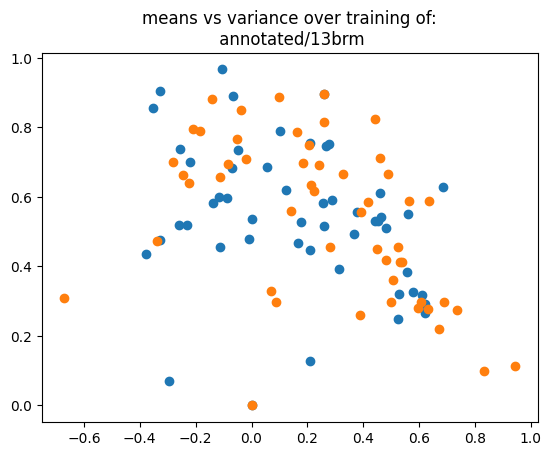

In [59]:
cpd = compdict('dpo13b', '13brm')

In [61]:
def print_outs(tmpdf, d1, d2):
    # go through all rows
    for i, row in tmpdf.iterrows():
        print("______________")
        print("mean correlation of ", d1, ":", row[d1+"mean"])
        print("mean correlation of ", d2, ":", row[d2+"mean"])
        print(row['question'])
        for j in [0,4]:
            print("*********\n outputs from ", ks[j])
            for k in range(4):
                print("gold ", row['annotated'][j][k], " ; ", d1, " ", row[d1][j][k], " ; ", d2, " ", row[d2][j][k])
                print(row['responses'][j][k].split("Answer:")[1])
        #print(row)

In [98]:
tmp = cpd[(cpd['13brmmean']>.2) & (cpd['dpo13bmean']>0.2)]

In [93]:
tmp

,dpo13bmean,13brmmean,dpo13bvar,13brmvar,question,responses,dpo13b,13brm,annotated
11,0.265409,-0.114064,0.747033,0.655628,nifi executestream how to pass the output of t...,[[Question: nifi executestream how to pass the...,"[[-1.146970623581067, -1.1314609622093936, -1....","[[-0.3937988281, -1.111328125, 4.8828125, -0.3...","[[3.0, 3.5, 3.5, 4.5], [4.0, 2.5, 4.5, 5.0], [..."
40,0.000943,-0.050986,0.537483,0.765129,can you write a cnc machine program?\n\n,[[Question: can you write a cnc machine progra...,"[[-1.087308866841715, -1.087308866841715, -1.0...","[[-0.1276855469, -0.1276855469, -0.11169433590...","[[2.0, 2.0, 2.0, 2.0], [5.0, 4.5, 4.5, 2.5], [..."
44,0.609999,-0.038659,0.318660,0.848737,Summarise how to apply for an Arts Council gra...,[[Question: Summarise how to apply for an Arts...,"[[-1.1344895178413978, -1.1426226159774093, -1...","[[1.462890625, 1.498046875, 0.8969726562, 2.19...","[[4.0, 4.5, 3.5, 4.5], [3.5, 5.0, 4.0, 5.0], [..."
46,0.365738,-0.281410,0.493868,0.699928,Explain simply why 7 is the correct answer to:...,[[Question: Explain simply why 7 is the correc...,"[[-1.1005821046859314, -1.107081688086066, -1....","[[0.62890625, -0.1079711914, 0.1848144531, -1....","[[1.0, 1.0, 1.0, 2.5], [1.0, 1.0, 1.0, 5.0], [..."


In [ ]:
print_outs(tmp, 'dpo13b', '13brm')

In [101]:
len(cpd[(cpd['13brmmean']>0.3) & (cpd['dpo13bmean']>0.3)])/len(cpd[(cpd['13brmmean']>0.3)])

0.5416666666666666

In [51]:
cpd['question'][4]

"In this task you will be given an answer to a question. You need to generate a question. The answer given should be a correct answer for the generated question.\nOne example is below.\nQ: This list contains the top 25 accounts with the most followers on the social photo-sharing platform Instagram. As of May 2018, the most followed user is Instagram's own account, with over 235 million followers. Selena Gomez is the most followed individual, with over 137 million followers. Ten accounts have exceeded 100 million followers on the site.\nA: who has the maximum number of followers on instagram\nRationale: The answer is talking about the Instagram accounts that have the most followers. The question asking about the maximum number of followers. So this is a good example.\nQ: 'Otherside' refers to former band member Hillel Slovak, who died of a heroin overdose on June 25, 1988. The song talks about his struggles from this addiction.\nA:\n\n"

In [ ]:
# TODO get a scatter plot of correlation variance vs mean for individual examples, for some pair distribution
# TODO get some notion of 

In [62]:
def comp_plot(base, lfunct=corrlines, excl=[]):
    cdists = lfunct(alldata, base)
    x = [0, 25, 50, 75, 100, 200, 400, 750, 950]
    # Plot each line
    for key in cdists:
        if key in excl:
            continue
        print(key, len(cdists[key]))
        plt.plot(x, cdists[key], label=key)
    
    # Adding labels and title
    plt.xlabel('Train Steps')
    plt.ylabel('Mean Spearman Correlation')
    plt.title('Correlations vs '+base+" over training")
    plt.legend()
    
    # Show the plot
    plt.show()

In [34]:
stmp = alldata['sft']['tulu13b']['scores']
mean([stdev(s) for s in stmp])

53.10008731211543

7brm 9
dpo7b 9
dpo13b 9
annotated 9


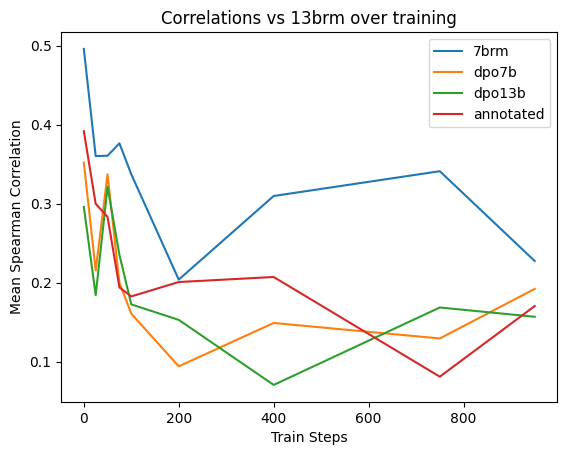

In [68]:
comp_plot("13brm", corrlines, ['tulu7b', 'tulu13b'])

plt.hist(cdists[2])

In [ ]:
spearmanr([1,2], [1,3])

In [ ]:
alldata = load_jsons()

In [ ]:
alldata['sft']['dpo13b']